### Imports

In [1]:
import struct
import xml.etree.ElementTree as ET

from datetime import datetime, timedelta, timezone

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import mlab
from scipy.constants import pi, c
from scipy.fft import fft, ifft, fftshift, ifftshift, ifft2, fft2
from scipy.spatial.transform import Rotation
from scipy.interpolate import interp1d

from decoding import get_header_dict, packet_generator_from_file, packet_generator, build_data_word_dict, index_decoder, annotation_decoder
from packet import Packet
from utils import create_bit_string, find_packet_of_type, time_packet_generation
from structs import SUB_COMM_KEY_POS, SUB_COMM_KEY_VAL, WORD_SIZE, F_REF

### Packet Decoding Functions

In [2]:
def get_all_data_packets_from_file(filename):
    packets = []
    indexes = []
    index = 0
    with open(filename, 'rb') as data:
        PacketGenerator = packet_generator(data)
        while (data):
            try:
                packet = next(PacketGenerator)
                packets.append(packet)
                indexes.append(index)
                index += 1
            except ValueError as ve:
                break
    return packets, indexes

def get_packets_in_swath_from_file(filename, swath_num):
    with open(filename, 'rb') as file:
        return get_packets_in_swath(file, swath_num)

def get_packets_in_swath(data, swath_num):
    PacketGenerator = packet_generator(data)
    swath_packets = []
    while (data):
        try:
            packet = next(PacketGenerator)
            if packet.data_format() == 'D':
                if packet.get_secondary_header()['swath_number'] == swath_num:
                    swath_packets.append(packet)
        except ValueError as ve:
            break
    return swath_packets  

def get_packets_in_bursts(swath_packets):
    bursts = []
    burst_packets = []
    previous_az = 0
    index = 0
    for packet in swath_packets:
        az = packet.get_secondary_header()['azimuth_beam_address']
        if index == 0:
            previous_az = az
        if az != previous_az and az != previous_az + 1:
            bursts.append(burst_packets)
            burst_packets = []
        burst_packets.append(packet)
        previous_az = az
        if index == len(swath_packets) - 1:
            bursts.append(burst_packets)
        index += 1
    return bursts

def get_packets_in_burst(swath_packets, burst_num):
    bursts = get_packets_in_bursts(swath_packets)
    return bursts[burst_num]

def decode_signals(packets):
    signals = []
    index = 0
    for packet in packets:
        if index % 100 == 0:
            print(f"{index} of {len(packets)}")
        signals.append(packet.get_complex_samples()[0])
        index += 1
    return np.asarray(signals)

### Time Functions

In [3]:
def mjd2000_time_to_datetime(gps_time_seconds):
    mjd2000_epoch = datetime(2000, 1, 1)
    current_time = gps_epoch + timedelta(seconds=gps_time_seconds)

def gps_time_to_datetime(gps_time_seconds):
    # GPS epoch is January 6, 1980, 00:00:00 UTC
    gps_epoch = datetime(1980, 1, 6)
    current_time = gps_epoch + timedelta(seconds=gps_time_seconds)
    return current_time
    
def gps_time_to_seconds_since_midnight(gps_time_seconds):
    # GPS epoch is January 6, 1980, 00:00:00 UTC
    gps_epoch = datetime(1980, 1, 6)
    whole_seconds = int(gps_time_seconds)
    fractional_seconds = gps_time_seconds - whole_seconds
    current_time = gps_epoch + timedelta(seconds=whole_seconds)
    seconds_since_midnight = (
        current_time.hour * 3600 +
        current_time.minute * 60 +
        current_time.second +
        fractional_seconds
    )
    return seconds_since_midnight

def data_word_time_stamp_to_seconds(time_stamp):
    time_stamp = time_stamp[8:64]
    num = 0
    for i in range(0, 32):
        num += int(time_stamp[i]) * (2 ** (32-i-1))
    for i in range(33, 56):
        num += int(time_stamp[i]) * (2 ** (-i))
    return num

def get_gps_time_from_packet(packet):
    header = packet.get_secondary_header()
    seconds = header['coarse_time']
    sub_seconds = 1 / header['fine_time']
    return gps_time_to_seconds_since_midnight(seconds + sub_seconds)

def annotation_time_to_datetime(days, milliseconds, microseconds):
    mj2000_epoch = datetime(2000, 1, 1)
    current_time = mj2000_epoch + timedelta(days=days, seconds=0, milliseconds=milliseconds, microseconds=microseconds)
    return current_time

def get_azimuth_time_from_record(record):
    days = record['days_ul']
    milliseconds = record['milliseconds_ul']
    microseconds = record['microseconds_ul']
    return annotation_time_to_datetime(days, milliseconds, microseconds)

### State Vector Functions

In [4]:
def to_float32(bit_string):
    int_representation = int(bit_string, 2)
    float_value = struct.unpack('f', struct.pack('I', int_representation))[0]
    return float_value

def to_float64(bit_string):
    int_representation = int(bit_string, 2)
    float_value = struct.unpack('d', struct.pack('Q', int_representation))[0]
    return float_value

def build_data_word_dict(packets, indexes, times):
    data_word_dicts = []
    sub_comm_dict = SUB_COMM_KEY_VAL.copy()
    initial_data_word_index = 0
    sc_data_word_index = 0
    for i in range(len(packets)):
        packet = packets[i]
        secondary_header = packet.get_secondary_header()
        sc_data_word_index = secondary_header['sc_data_word_index']
        if i == 0:
            initial_data_word_index = sc_data_word_index
        else:
            if sc_data_word_index == initial_data_word_index:
                sub_comm_dict['azimuth_time'] = times[indexes[i]]
                data_word_dicts.append(sub_comm_dict)
                sub_comm_dict = SUB_COMM_KEY_VAL.copy()
        data_word =  secondary_header['sc_data_word']
        key, pos = SUB_COMM_KEY_POS[sc_data_word_index]
        pos = pos * WORD_SIZE
        sub_comm_dict[key] = sub_comm_dict[key][0:pos] + data_word + sub_comm_dict[key][pos+WORD_SIZE:]
    if sc_data_word_index != initial_data_word_index:
        data_word_dicts.append(sub_comm_dict)
    for i in range(len(data_word_dicts)):
        data_word_dicts[i]['x_axis_position'] = to_float64(data_word_dicts[i]['x_axis_position'])
        data_word_dicts[i]['y_axis_position'] = to_float64(data_word_dicts[i]['y_axis_position'])
        data_word_dicts[i]['z_axis_position'] = to_float64(data_word_dicts[i]['z_axis_position'])
        data_word_dicts[i]['x_axis_velocity'] = to_float32(data_word_dicts[i]['x_axis_velocity'])
        data_word_dicts[i]['y_axis_velocity'] = to_float32(data_word_dicts[i]['y_axis_velocity'])
        data_word_dicts[i]['z_axis_velocity'] = to_float32(data_word_dicts[i]['z_axis_velocity'])
        data_word_dicts[i]['q0_quaternion']   = to_float32(data_word_dicts[i]['q0_quaternion'])
        data_word_dicts[i]['q1_quaternion']   = to_float32(data_word_dicts[i]['q1_quaternion'])
        data_word_dicts[i]['q2_quaternion']   = to_float32(data_word_dicts[i]['q2_quaternion'])
        data_word_dicts[i]['q3_quaternion']   = to_float32(data_word_dicts[i]['q3_quaternion'])
        data_word_dicts[i]['omega_x']         = to_float32(data_word_dicts[i]['omega_x'])
        data_word_dicts[i]['omega_y']         = to_float32(data_word_dicts[i]['omega_y'])
        data_word_dicts[i]['omega_z']         = to_float32(data_word_dicts[i]['omega_z'])
    return data_word_dicts

def get_times_from_subcomm_dicts(subcomm_dicts):
    times = []
    for subcomm_dict in subcomm_dicts[:-1]:
        gps_time = data_word_time_stamp_to_seconds(subcomm_dict["data_time_stamp"])
        data_time = gps_time_to_datetime(gps_time)
        times.append(data_time)
    return np.asarray(times)

def get_velocities_from_subcomm_dicts(subcomm_dicts):
    velocities = []
    for subcomm_dict in subcomm_dicts[:-1]:
        vx = subcomm_dict["x_axis_velocity"]
        vy = subcomm_dict["y_axis_velocity"]
        vz = subcomm_dict["z_axis_velocity"]
        velocities.append([vx, vy, vz])
    return np.asarray(velocities, dtype=np.float64)

def get_positions_from_subcomm_dicts(subcomm_dicts):
    positions = []
    for subcomm_dict in subcomm_dicts[:-1]:
        px = subcomm_dict["x_axis_position"]
        py = subcomm_dict["y_axis_position"]
        pz = subcomm_dict["z_axis_position"]
        positions.append([px, py, pz])
    return np.asarray(positions, dtype=np.float64)

def quaternion_to_rotation_matrix(q):
    """https://forum.step.esa.int/uploads/default/original/2X/3/315f415284743cf42be03a464121df1ca337a26d.pdf"""
    q0, q1, q2, q3 = q
    e00 = q0**2 - q1**2 - q2**2 + q3**2
    e01 = 2 * (q0 * q1 + q2 * q3)
    e02 = 2 * (q0 * q2 - q1 * q3)
    e10 = 2 * (q0 * q1 - q2 * q3)
    e11 = -q0**2 + q1**2 - q2**2 + q3**2
    e12 = 2 * (q1 * q2 + q0 * q3)
    e20 = 2 * (q0 * q2 + q1 * q3)
    e21 = 2 * (q1 * q2 - q0 * q3)
    e22 = -q0**2 - q1**2 + q2**2 + q3**2
    R = np.array([
        [e00, e01, e02],
        [e10, e11, e12],
        [e20, e21, e22]
    ])
    return R

def get_quaternions_from_subcomm_dicts(subcomm_dicts):
    quaternions = []
    for subcomm_dict in subcomm_dicts[:-1]:
        q0 = subcomm_dict['q0_quaternion']
        q1 = subcomm_dict['q1_quaternion']
        q2 = subcomm_dict['q2_quaternion']
        q3 = subcomm_dict['q3_quaternion']
        m_eo_cfi = quaternion_to_rotation_matrix([q1, q2, q3, q0])
        m = np.asarray([-m_eo_cfi[1], -m_eo_cfi[0], -m_eo_cfi[2]])
        rotation_eo_cfi_sat_att = Rotation.from_matrix(m)
        q0, q1, q2, q3 = rotation_eo_cfi_sat_att.as_quat()
        quaternions.append([-q0, -q1, -q2, q3])
    return np.asarray(quaternions, dtype=np.float64)

def get_angular_rates_from_subcomm_dicts(subcomm_dicts):
    angular_rates = []
    for subcomm_dict in subcomm_dicts[:-1]:
        omega_x = subcomm_dict['omega_x']
        omega_y = subcomm_dict['omega_y']
        omega_z = subcomm_dict['omega_z']
        angular_rates.append([omega_x, omega_y, omega_z])
    return np.asarray(angular_rates, dtype=np.float64)

def quaternion_to_rotation_matrix_for_euler(q):
    q0, q1, q2, q3 = q
    R = np.array([
        [1 - 2 * (q2**2 + q3**2), 2 * (q1*q2 - q3*q0), 2 * (q1*q3 + q2*q0)],
        [2 * (q1*q2 + q3*q0), 1 - 2 * (q1**2 + q3**2), 2 * (q2*q3 - q1*q0)],
        [2 * (q1*q3 - q2*q0), 2 * (q2*q3 + q1*q0), 1 - 2 * (q1**2 + q2**2)]
    ])
    return R

def get_euler_angles(quaternions):
    """ Thanks to this
    https://www.researchgate.net/post/Can-someone-explain-the-Sentinel-1-orientation-quanternion-vs-pitch-roll-yaw-numbers-to-me
    and this
    https://forum.step.esa.int/uploads/default/original/2X/3/315f415284743cf42be03a464121df1ca337a26d.pdf
    """
    euler_angles = []
    for quaternion in quaternions:
        q0, q1, q2, q3 = quaternion
        rotation = Rotation.from_quat(quaternion).as_euler('YXZ', degrees=True)
        pitch = -rotation[0]
        roll = -rotation[1]
        yaw = rotation[2]
        euler = (np.asarray([roll, pitch, yaw]) * 2 * pi / 360.0)
        euler_angles.append(euler)
    return np.asarray(euler_angles)

def get_state_vectors_from_subcomm_dicts(subcomm_dicts):
    times = list(get_times_from_subcomm_dicts(subcomm_dicts))
    unique_times = list(dict.fromkeys(times))
    unique_indexes = [times.index(unique_time) for unique_time in unique_times]
    quaternions = get_quaternions_from_subcomm_dicts(subcomm_dicts)[unique_indexes]
    return {
        "time": unique_times,
        "azimuth_time": [subcomm_dicts[i]["azimuth_time"] for i in unique_indexes],
        "velocity": get_velocities_from_subcomm_dicts(subcomm_dicts)[unique_indexes],
        "position": get_positions_from_subcomm_dicts(subcomm_dicts)[unique_indexes],
        "quaternion": get_quaternions_from_subcomm_dicts(subcomm_dicts)[unique_indexes],
        "angular_rate": get_angular_rates_from_subcomm_dicts(subcomm_dicts)[unique_indexes],
        "euler_angle": get_euler_angles(quaternions)  
    }

In [5]:
filename_prefix = '/media/andrew/linux/data/strong/strong'

data_filename = filename_prefix + '.dat'
annotation_filename = filename_prefix + '_annot.dat'
index_filename = filename_prefix + '_index.dat'

data = open(data_filename, 'rb')
annot_data = open(annotation_filename, 'rb')
index_data = open(index_filename, 'rb')

#### Decode Annotation Files

In [6]:
annotation_records = annotation_decoder(annot_data)
index_records = index_decoder(index_data)

#### Read Packets

In [7]:
iw1 = get_packets_in_bursts(get_packets_in_swath_from_file(data_filename, 10))
iw2 = get_packets_in_bursts(get_packets_in_swath_from_file(data_filename, 11))
iw3 = get_packets_in_bursts(get_packets_in_swath_from_file(data_filename, 12))

#### Getting State Vectors

In [8]:
packets, indexes = get_all_data_packets_from_file(data_filename)
azimuth_times = [get_azimuth_time_from_record(record) for record in annotation_records]

In [9]:
subcomm_dicts = build_data_word_dict(packets, indexes, azimuth_times)
state_vectors = get_state_vectors_from_subcomm_dicts(subcomm_dicts)

In [10]:
state_vectors["quaternion"][0:6]

array([[ 0.12794492,  0.44567544, -0.81261006,  0.35308412],
       [ 0.12819179,  0.44524899, -0.81273937,  0.35323494],
       [ 0.12843827,  0.44482148, -0.81286891,  0.35338591],
       [ 0.12868545,  0.44439358, -0.81299862,  0.35353592],
       [ 0.1289318 ,  0.44396596, -0.81312808,  0.35368564],
       [ 0.12917995,  0.44353914, -0.81325661,  0.35383507]])

In [11]:
(state_vectors["euler_angle"][0:6] * 360) / (2 * pi)

array([[ -54.55487657,  -10.61061144, -127.54675134],
       [ -54.51883829,  -10.54076813, -127.57596517],
       [ -54.48265178,  -10.47098447, -127.60510513],
       [ -54.44646696,  -10.40107439, -127.63437756],
       [ -54.4102649 ,  -10.33140197, -127.66349329],
       [ -54.37425117,  -10.26164268, -127.69256476]])

In [12]:
state_vectors['angular_rate'][0:6]

array([[ 6.52783347e-05, -9.45762265e-04, -4.81955765e-04],
       [ 6.58083009e-05, -9.47262219e-04, -4.81957453e-04],
       [ 6.62077146e-05, -9.46137414e-04, -4.81729832e-04],
       [ 6.51473747e-05, -9.46511456e-04, -4.81725991e-04],
       [ 6.87287320e-05, -9.44263127e-04, -4.81049938e-04],
       [ 6.48850400e-05, -9.43512481e-04, -4.80807212e-04]])

#### Interpolating State Vectors:

There are generally far fewer state vectors than burst samples, as the state vectors are sampled at a rate of 1 Hz. Thus, they need to be interpolated as a function of time, so that the packets can get an approximate state vector for their respective azimuth time.

In [13]:
def datetime_to_seconds(datetimes):
    gps_epoch = datetime(1980, 1, 6)
    seconds = np.array([(dt - gps_epoch).total_seconds() for dt in datetimes])
    return seconds

def interpolate_state_vector(state_vector, state_vector_times):
    time_seconds = datetime_to_seconds(state_vector_times)
    interp_functions = []
    for i in range(state_vector.shape[1]):
        interp_functions.append(interp1d(time_seconds, state_vector[:, i], kind='linear', fill_value="extrapolate"))
    return tuple(interp_functions)

In [14]:
x_interp, y_interp, z_interp = interpolate_state_vector(state_vectors["position"], state_vectors["time"])
vx_interp, vy_interp, vz_interp = interpolate_state_vector(state_vectors["velocity"], state_vectors["time"])
q0_interp, q1_interp, q2_interp, q3_interp = interpolate_state_vector(state_vectors["quaternion"], state_vectors["time"])
roll_interp, pitch_interp, yaw_interp = interpolate_state_vector(state_vectors["euler_angle"], state_vectors["time"])

In [15]:
azimuth_times_in_seconds = datetime_to_seconds(azimuth_times)
t0 = azimuth_times_in_seconds[0]

In [16]:
x, y, z = x_interp(t0), y_interp(t0), z_interp(t0)
vx, vy, vz = vx_interp(t0), vy_interp(t0), vz_interp(t0)
q0, q1, q2, q3 = q0_interp(t0), q1_interp(t0), q2_interp(t0), q3_interp(t0)

In [17]:
print(f"Initial Position: {x, y, z}")
print(f"Initial Velocity: {vx, vy, vz}")
print(f"Initial Quaternions: {q0, q1, q2, q3}")
print(f"Initial Roll, Pitch, Yaw: {(get_euler_angles([[q0, q1, q2, q3]]) * 360) / (2 * pi)}")

Initial Position: (array(3970171.00947486), array(2563537.49608503), array(5258569.95735754))
Initial Velocity: (array(-3535.8000866), array(-4597.4070823), array(4898.55762181))
Initial Quaternions: (array(0.12391744), array(0.45263269), array(-0.81050048), array(0.35062347))
Initial Roll, Pitch, Yaw: [[ -55.13982139  -11.76341556 -127.0556338 ]]


#### Antenna Steering Angle and Steering Rate

**From the [ESA Forums](https://forum.step.esa.int/t/level-0-azimuth-beam-address-index-look-up-table-conversion/10854):</br>**
"Based on examining the burst time, the azimuth steering rate, and the actual used span of azimuth beam addresses, I believe the full span of the azimuth steering to cover +/-0.018 radians (i.e. - when the azimuth beam address is 0, the electronically steerable antenna is pointing -0.018 radians in azimuth, when the azimuth beam address is 512, the elcetronically steerable antenna is pointing 0 radians in azimuth (‘broadside’), and when the azimuth beam address is 1023, the electronically steerable antenna is pointing +0.018 radians in azimuth)."

In [18]:
def azimuth_beam_address_to_angle(azimuth_beam_address):
    first_address = -0.018
    last_address = 0.018
    num_addresses = 1024
    azimuth_angles = np.linspace(first_address, last_address, num_addresses)
    return azimuth_angles[azimuth_beam_address]

def get_azimuth_steering_angles(packets):
    azimuth_angles = []
    for packet in packets:
        header = packet.get_secondary_header()
        azimuth_beam_address = header["azimuth_beam_address"]
        azimuth_angles.append(azimuth_beam_address_to_angle(azimuth_beam_address))
    return np.asarray(azimuth_angles)

def get_azimuth_steering_rate(azimuth_angles, pri):
    differences = []
    for i in range(len(azimuth_angles)):
        if (i != 0):
            difference = azimuth_angles[i] - azimuth_angles[i-1]
            differences.append(difference)
    average_difference = sum(differences) / len(azimuth_angles)
    steering_rate_rad_per_second = average_difference / pri
    return steering_rate_rad_per_second

In [19]:
first_header = iw1[1][0].get_secondary_header()
pri = first_header["pri"] * 1e-6
azimuth_angles_radians = get_azimuth_steering_angles(iw1[1])
azimuth_steering_rate_rad_s = get_azimuth_steering_rate(azimuth_angles_radians, pri)
azimuth_steering_rate_deg_s = (azimuth_steering_rate_rad_s * 360) / (2 * pi)
print(f"First Azimuth Angle: {azimuth_angles_radians[0]} radians")
print(f"Last Azimuth Angle: {azimuth_angles_radians[-1]} radians")
print(f"Azimuth Steering Rate: {azimuth_steering_rate_rad_s} rad/s")
print(f"Azimuth Steering Rate: {azimuth_steering_rate_deg_s} deg/s")

First Azimuth Angle: -0.011806451612903225 radians
Last Azimuth Angle: 0.010997067448680349 radians
Azimuth Steering Rate: 0.02779033590278584 rad/s
Azimuth Steering Rate: 1.592268958480513 deg/s


#### Doppler Centroid Rate

The doppler centroid rate induced by the antenna scanning is calculated by:
$$ k_s(\eta) = -\frac{2V_s}{\lambda}\cos(k_{\psi}(\eta - \frac{T_b}{2}))k_{\psi}(\eta) \approx -\frac{2 V_s}{\lambda}k_{\psi} $$

In [20]:
def calculate_doppler_centroid_rate(velocity, steering_rate):
    wavelength = c / 5.405000454334350e+09
    return ((-2 * velocity) / wavelength) * steering_rate

In [21]:
initial_velocity = np.linalg.norm(state_vectors["velocity"][0])
initial_doppler_centroid_rate = calculate_doppler_centroid_rate(initial_velocity, azimuth_steering_rate_rad_s)
print(f"Initial Velocity: {initial_velocity} m/s")
print(f"Initial Doppler Centroid Rate: {initial_doppler_centroid_rate} Hz/s")

Initial Velocity: 7590.144777163056 m/s
Initial Doppler Centroid Rate: -7605.869744077674 Hz/s


##### Slant Ranges and $R_0$

In [22]:
# All slant ranges calculated this way will be equal for a given burst.
# This is due to the fact that the pulse timing parameters are only
# updated at the beginning of a burst.
slant_ranges = []
for packet in iw1[1]:
    packet_header = packet.get_secondary_header()
    delta_t_suppressed = (320 / (8 * F_REF)) * 1e-6
    start_time = packet_header["swst"] * 1e-6
    pri = packet_header["pri"] * 1e-6
    rank = packet_header["rank"]
    delay = rank * pri + start_time + delta_t_suppressed
    slant_range = delay * c / 2
    slant_ranges.append(slant_range)
R_0 = min(slant_ranges)

#### Calculating $V_r$

1. Specify the attitude at the central, beam-center, time. If no attitude data is available, set to 0 or a nominal value.
2. Using a circular orbit model with approximately the same radius as the state vector at the central time, an orbit time corresponding to the state vector position at the central time, and a beam nadir angle that gives the disired slant range, compute the beam view vector in ECR coordinates. See Apendix 12A.
3. Using the central state vector position, find the target location by solving for the intersection of the view vector with the Earth's surface. Find the range from the satellite to the target. See Appendix 12A.
4. Using the satellite's position at the other state vectors, find the ranges $R(\eta)$ to the same target.
5. Use the interpolated state vectors to find the time and satellite position when the range to the target is a minimum. This gives the time of zero Doppler, $\eta^{'}_{0}$, and the range of closest approach, $R_0$, corresponding to the target.
6. Using the time of zero Doppler and the range of closest approach from the previous step as the origin of the hyperbola, find the coefficient $V^2_r$ that gives the best fit to the range points in the hyperbolic model:
   $$ R^{2}(\eta^{'}) = R^2_0 + V^{2}_{r}(\eta^{'} - \eta^{'}_{0})^2 $$
   This gives an estimate of $V_r$ at the specified range.
7. Repeat the steps at various ranges to get estimates of $V_r$ that cover the swath (or burst).
8. Fit a low order polynomial through the $V_r$ values, so that $V_r$ is available as a function of range.

In [24]:
# Satellite Reference Frame

gravitation = 3.987e+14
wgs84_equatorial_radii = 6_378_137.0
ref_altitude = 711_700 # meter
ref_orbit_radius = ref_altitude + wgs84_equatorial_radii

S0 = np.asarray([0, 0, 0])

Vsat = np.sqrt(gravitation / ref_orbit_radius)
V0 = np.asarray([0, 0, Vsat])

beam_off_nadir = 0.0
U0f = np.asarray([-np.cos(beam_off_nadir), np.sin(beam_off_nadir), 0])

In [26]:
# Rotate to Earth Center

# In book:
# Pitch is clockwise around positive y-axis
# Yaw is clockwise around positive x-axis
# Roll is clockwise around positive z-axis

yaw = 0
pitch = 0
roll = 0

nose_up = np.asarray([
    [np.cos(pitch),  0, np.sin(pitch)],
    [0,              1,             0],
    [-np.sin(pitch), 0, np.cos(pitch)]
])

nose_left = np.asarray([
    [1,          0,             0],
    [0, np.cos(yaw), -np.sin(yaw)],
    [0, np.sin(yaw),  np.cos(yaw)]
])

U1 = np.dot(nose_left, np.dot(nose_up, U0f))
S1 = S0 + np.asarray([ref_orbit_radius, 0, 0])
V1 = V0

**OR**

#### Calculating $V_r$

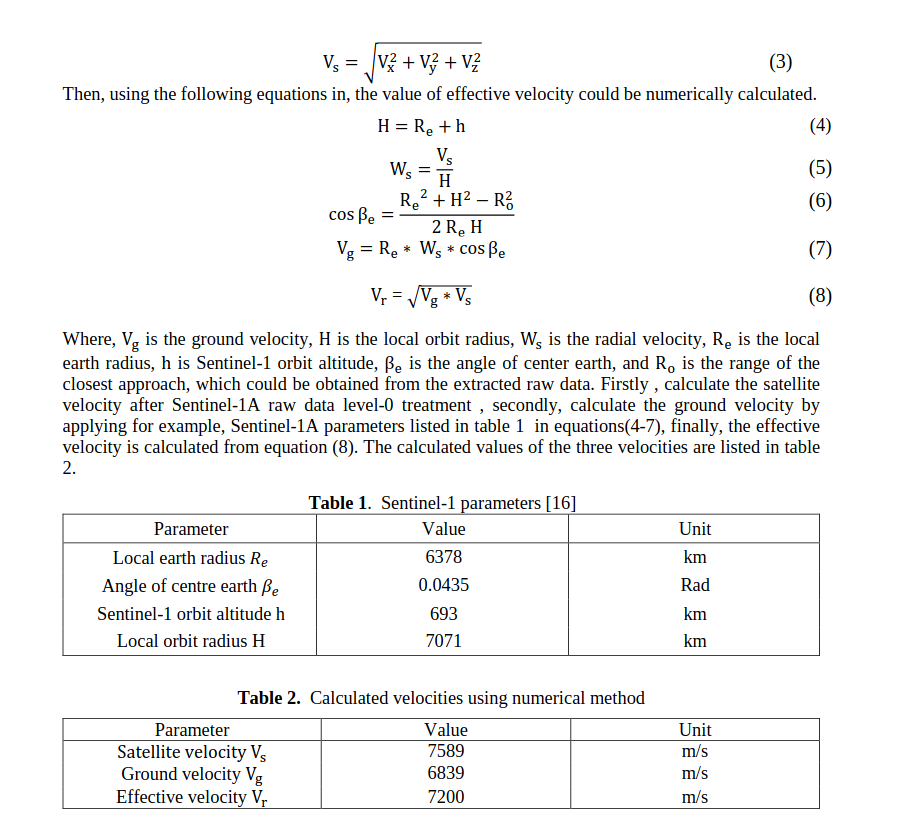

In [29]:
# Saving for Later

def datetime_to_mjd2000(dt):
    epoch = datetime(2000, 1, 1, 12, 0, 0)  # The epoch for MJ2000 (January 1, 2000, 12:00 TT)
    delta = dt - epoch
    return delta.total_seconds() / (24 * 3600)

def gmst_from_datetime(dt):
    mjd2000 = datetime_to_mjd2000(dt)
    # GMST calculation in degrees
    gmst_deg = 280.46061837 + 360.98564736629 * mjd2000
    gmst_rad = np.radians(gmst_deg % 360)
    return gmst_rad

def ecef_to_eci(position_ecef, dt):
    # Calculate GMST in radians
    gmst = gmst_from_datetime(dt)
    # Define the rotation matrix from ECEF to ECI (rotation about Z-axis by GMST)
    rotation_matrix = np.array([
        [np.cos(gmst), np.sin(gmst), 0],
        [-np.sin(gmst), np.cos(gmst), 0],
        [0, 0, 1]
    ])
    # Rotate the ECEF position vector to ECI
    position_eci = np.dot(rotation_matrix, position_ecef)
    return position_eci

def eci_to_ecef(position_eci, dt):
    # Calculate GMST in radians
    gmst = gmst_from_datetime(dt)
    # Define the inverse rotation matrix from ECI to ECEF (rotation about Z-axis by GMST)
    rotation_matrix = np.array([
        [np.cos(gmst), -np.sin(gmst), 0],
        [np.sin(gmst), np.cos(gmst), 0],
        [0, 0, 1]
    ])
    # Rotate the ECI position vector to ECEF
    position_ecef = np.dot(rotation_matrix, position_eci)
    return position_ecef

def ecef_to_latlon(position_ecef):
    x, y, z = position_ecef
    lon = np.arctan2(y, x)
    r = np.sqrt(x**2 + y**2)
    lat = np.arctan2(z, r)
    lat = np.degrees(lat)
    lon = np.degrees(lon)
    return lat, lon

index = 8

packet = packets[index]
packet_header = packet.get_secondary_header()
sampling_window_length = packet_header["swl"] * 10e-6
txpl = packet_header["pulse_length"]
pulse_length = txpl * 10e-6
range_decimation = packet_header["range_decimation"]
delta_t_suppressed = (320 / (8 * F_REF)) * 1e-6
start_time = packet_header["swst"] * 1e-6
pri = packet_header["pri"] * 1e-6
rank = packet_header["rank"]
delay = rank * pri + start_time + delta_t_suppressed
azimuth_time_dt = azimuth_times[index]
azimuth_time_s = azimuth_times_in_seconds[index]
slant_range = delay * c / 2

header = packets[index].get_secondary_header()
elevation_range = np.linspace(-0.000261799, 0.000261799, 16)
elevation_angle = elevation_range[header['elevation_beam_address']]
azimuth_angle = azimuth_beam_address_to_angle(header['azimuth_beam_address'])
azimuth_angle

time = state_vectors['time'][index]
roll, pitch, yaw = tuple(state_vectors['euler_angle'][index])
position_ecef = state_vectors['position'][index]
position_eci = ecef_to_eci(position_ecef, time)

lat, lon = ecef_to_latlon(eci_to_ecef(position_eci, time))

def quaternion_to_rotation_matrix(q):
    """https://forum.step.esa.int/uploads/default/original/2X/3/315f415284743cf42be03a464121df1ca337a26d.pdf"""
    q0, q1, q2, q3 = q
    e00 = q0**2 - q1**2 - q2**2 + q3**2
    e01 = 2 * (q0 * q1 + q2 * q3)
    e02 = 2 * (q0 * q2 - q1 * q3)
    e10 = 2 * (q0 * q1 - q2 * q3)
    e11 = -q0**2 + q1**2 - q2**2 + q3**2
    e12 = 2 * (q1 * q2 + q0 * q3)
    e20 = 2 * (q0 * q2 + q1 * q3)
    e21 = 2 * (q1 * q2 - q0 * q3)
    e22 = -q0**2 - q1**2 + q2**2 + q3**2
    R = np.array([
        [e00, e01, e02],
        [e10, e11, e12],
        [e20, e21, e22]
    ])
    return R

# Function to compute the look vector from the satellite to the target
def compute_look_vector(position_sat, quaternions):
    # Convert the quaternion to a rotation matrix (from EO CFI to ECEF)
    R_eci_to_ecef = quaternion_to_rotation_matrix(quaternions)

    # The boresight vector (x-axis) in the EO CFI frame
    boresight_vector_eci = np.angle(np.array([0, 0, -1]))

    # Apply the rotation to get the look vector in ECEF frame
    look_vector_ecef = np.dot(R_eci_to_ecef, boresight_vector_eci)

    return look_vector_ecef

look_vector = compute_look_vector(position_ecef, [q1, q2, q3, q0])

def get_target_position_eci(position_eci, look_vector):
    wgs84_equatorial_radii = 6_378_137.0
    wgs84_polar_radii = 6_356_752.3142
    wgs84_eccentricity = 0.0067395

    i = 2
    
    denominator = 1 + wgs84_eccentricity * view_vector_eci[i]**2
    F = (np.dot(position_eci, view_vector_eci) + wgs84_eccentricity * position_eci[i] * view_vector_eci[i]) / denominator
    G = (np.dot(position_eci, position_eci) - wgs84_equatorial_radii**2 + wgs84_eccentricity * position_eci[i]**2) / denominator

    print(f"F: {F}")
    print(f"G: {G}")
    print(f"F**2-G: {F**2 - G}")
    
    range_to_target = -1*F - np.sqrt((F)**2 - (G))

    return position_eci + range_to_target * view_vector_eci

# target_position_eci = get_target_position_eci(position_ecef, look_vector)
# target_position_ecef = eci_to_ecef(target_position_eci, time)
# target_lat_lon = ecef_to_latlon(target_position_ecef)

# ecef_to_latlon(state_vectors['position'][index])